In [53]:
import pandas as pd
import numpy as np
data = pd.read_csv('mnist_test.csv')
data.head()



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

class LossFunction:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def loss(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        values = - self.y * np.log(prob) - (1 - self.y) * np.log(1 - prob)
        return np.nansum(values) / self.y.shape[0]

    def gradient(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        sub_coefficient = -(self.y - prob) 
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]
    
    def precision(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        prob = np.array(prob >= 0.5, dtype=np.int32)
        return np.sum(prob == self.y) / self.y.shape[0]


        


In [55]:
X = data.drop('label', axis=1).values
# X: shape m x 784
#append a column of 1s
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = data['label'].values
X.shape, y.shape


((10000, 785), (10000,))

In [56]:
loss_functions = []
for digit in range(10):
    y_digit = np.array(y == digit, dtype=np.int32)
    loss_functions.append(LossFunction(X, y_digit))

In [57]:
def gradient_descent(loss_func, starting_point, learning_rate = 0.00001, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        # print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
        cur_point = cur_point - learning_rate * grad
        if np.linalg.norm(grad) < precision:
            break
    return cur_point

In [58]:
optimal_points = []

for digit in range(10):
    optimal_point = gradient_descent(loss_functions[digit], np.zeros(X.shape[1]))
    print("Accuracy for digit {}: {}".format(digit, loss_functions[digit].precision(optimal_point)))
    optimal_points.append(optimal_point)

Accuracy for digit 0: 0.9875
Accuracy for digit 1: 0.9889
Accuracy for digit 2: 0.9711
Accuracy for digit 3: 0.9666
Accuracy for digit 4: 0.972
Accuracy for digit 5: 0.957
Accuracy for digit 6: 0.9784
Accuracy for digit 7: 0.9791
Accuracy for digit 8: 0.9348
Accuracy for digit 9: 0.949


In [59]:
def infer(X, optimal_points):
    prob = np.zeros((X.shape[0], 10))
    for digit in range(10):
        prob[:, digit] = sigmoid(np.dot(X, optimal_points[digit]))
    return np.argmax(prob, axis=1)

In [60]:
import matplotlib.pyplot as plt

def draw_digit(data, row_id):
    row = data.iloc[row_id]
    label = row['label']
    image = row.drop('label').values.reshape(28, 28)
    plt.title('Digit Label = {}'.format(label))
    plt.imshow(image, cmap='gray')
    plt.show()

In [61]:
data_test = pd.read_csv('mnist_test.csv')
X_test = data_test.drop('label', axis=1).values
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
y_test = data_test['label'].values

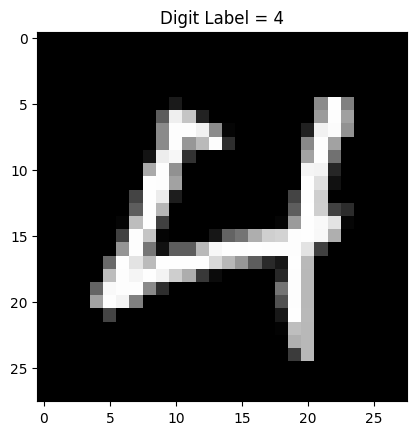

In [62]:
draw_digit(data_test, 2005)

In [63]:
infer(np.array([X_test[2005]]), optimal_points)

array([4], dtype=int64)

In [64]:
def evaluate(X, y, optimal_points):
    y_pred = infer(X, optimal_points)
    return np.sum(y_pred == y) / y.shape[0]
evaluate(X_test, y_test, optimal_points)

0.8819

In [65]:
# Immplementing the formula of softmax function to calculate the loss function for multiclass classification
def softmax(z):
    z -= np.max(z)
    return (np.exp(z).T / np.sum(np.exp(z), axis=0)).T

class MulticlassRegression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def loss_softmax(self, a: np.ndarray):
        prob = softmax(np.dot(self.X, a))``
        values = - np.log(prob[np.arrange(self.y.shape[0]), self.y])
        return np.nansum(values) / self.y.shape[0]
    
    def gradient_softmax(self, a: np.ndarray):
        prob = softmax(np.dot(self.X, a))
        sub_coefficient = prob - self.y
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]
    
    def precision_softmax(self, a:np.ndarray):
        prob = softmax(np.dot(self.X, a))
        prob = np.argmax(prob, axis = 0)
        return np.sum(prob == self.y) / self.y.shape[0]
    

In [66]:
# Implement focal loss to deal with the imbalanced data
class FocalLoss:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def focal_loss(self, a:np.ndarray, gamma = 2, alpha = 0.25):
        prob = softmax(np.dot(self.X, a))
        values = - alpha * (1 - prob) ** gamma * np.log(prob)
        return np.nansum(values) / self.y.shape[0]

    def gradient_focal_loss(self, a:np.ndarray, gamma = 2, alpha = 0.25):
        prob = softmax(np.dot(self.X, a))
        sub_coefficient = - alpha * (1 - prob) ** gamma * (gamma * prob * np.log(prob) + prob - 1)
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]

    def precision_focal_loss(self, a:np.ndarray):
        prob = softmax(np.dot(self.X, a))
        prob = np.argmax(prob, axis = 0)
        return np.sum(prob == self.y) / self.y.shape[0]



In [67]:

loss_functions = []
for digit in range(10):
    y_digit = np.array(y == digit, dtype=np.int32)
    loss_functions.append(FocalLoss(X, y_digit))

In [68]:
def gradient_softmax_process(loss_func, starting_point, learning_rate = 0.00001, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        grad = loss_func.gradient_focal_loss(cur_point)
        cur_point = cur_point - learning_rate * grad
        if np.linalg.norm(grad) < precision:
            break
    return cur_point

In [69]:
optimal_points = []

for digit in range(10):
    optimal_point = gradient_softmax_process(loss_functions[digit], np.zeros(X.shape[1]))
    print("Accuracy for digit {}: {}".format(digit, loss_functions[digit].precision_focal_loss(optimal_point)))
    optimal_points.append(optimal_point)

Accuracy for digit 0: 0.0
Accuracy for digit 1: 0.0


Accuracy for digit 2: 0.0
Accuracy for digit 3: 0.0
Accuracy for digit 4: 0.0
Accuracy for digit 5: 0.0
Accuracy for digit 6: 0.0
Accuracy for digit 7: 0.0
Accuracy for digit 8: 0.0
Accuracy for digit 9: 0.0
